# csv데이터불러오기

In [35]:
import os
import heartpy as hp
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal
import csv
import math
from hrvanalysis import get_frequency_domain_features

In [2]:
# csv파일 불러와서 ppg_data로 반환
def load_data(path):
    f = open(path, 'r', encoding='utf-8')
    rdr = csv.reader(f)
    for line in rdr:
        ppg_data=line
    f.close()
    return ppg_data    

# 데이터 정규화 0~1

In [3]:
from sklearn.preprocessing import MinMaxScaler

def normalization(ppg_data):
    ppg_data=np.array(ppg_data)
    # MinMaxScaler객체 생성
    scaler = MinMaxScaler()
    # MinMaxScaler 로 데이터 셋 변환. fit() 과 transform() 호출.  
    scaler.fit(ppg_data.reshape(len(ppg_data),1))
    ppg_scaled = scaler.transform(ppg_data.reshape(len(ppg_data),1))
    print(type(ppg_scaled))
#     plt.plot(ppg_scaled)
#     plt.show()
    return ppg_scaled.reshape(len(ppg_data))

# peak detection

In [5]:
# peak 찾는 함수(amplitude)
def detect_peak(hrdata,distance):
    point=scipy.signal.find_peaks(hrdata,distance=distance)
    peak=np.zeros(len(point[0]))
    for i in range(len(point[0])):
        peak[i]=(hrdata[point[0][i]])
# peak = peak 값 (y축값), point[0] = peak의 x위치
    return(peak,point[0])


# 시간축으로 변환

In [15]:
# time은 sec
def Totimedomain(ppg_data,sr,peaks_x,peaks_y):
    #data->timedomain
    num=len(ppg_data)
    time=np.linspace(0,num/sr ,num) # start,stop,num
    

    #peak->timedomain
    time_peaks_x=np.zeros_like(peaks_x,dtype=float)
    for i in range (len(peaks_x)):
        time_peaks_x[i]=time[peaks_x[i]]
     
    plt.scatter(time_peaks_x, peaks_y)
    plt.plot(time,ppg_data)
    plt.xlim([0, 10])
    plt.xlabel('time')
    plt.ylabel('signal')
    plt.show()
    
    return time , time_peaks_x

#cppg_peaks,cppg_points= detect_peak(cppg_scaled,100,1)
#ctime,c_ppg_peaks_x=Totimedomain(cppg_scaled,cppg_points,cppg_peaks)

# 신호전처리

## 1. bandpass filtering

In [7]:
def preprocessing(hrdata,cut_l,cut_h,sr):
    filtered = hp.filter_signal(hrdata, cutoff = cut_l, sample_rate = sr, order = 3, filtertype='lowpass')
    filtered = hp.filter_signal(filtered, cutoff = cut_h, sample_rate = sr, order = 3, filtertype='highpass')
    
    plt.subplot(1,2,1)
    plt.xlim([0, 1000])
    plt.plot(hrdata)

    plt.subplot(1,2,2)
    plt.xlim([0, 1000])
    plt.plot(filtered)
    plt.show()
    
    return filtered

<class 'list'>


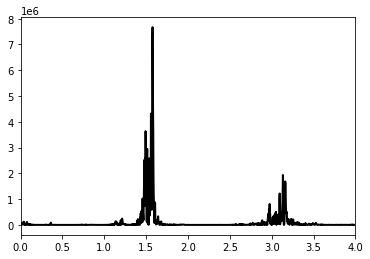

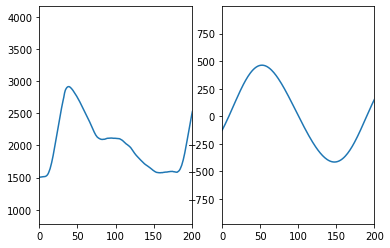

<class 'numpy.ndarray'>
91688
time: (91688,)


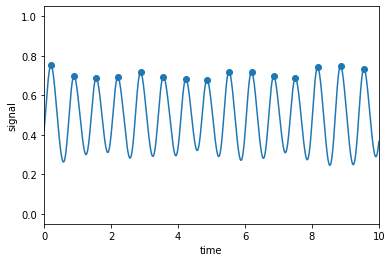

hrv_shape: (546,)
ppg_hrv_analysis: {'lf': 5.554683649731543e-06, 'hf': 1.2896154375616145e-05, 'lf_hf_ratio': 0.43072403508399804, 'lfnu': 30.105319021827302, 'hfnu': 69.8946809781727, 'total_power': 2.0301950396534903e-05, 'vlf': 1.8511123711872157e-06}


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


In [36]:
# 필터링 후 정규화 실험해보기.
from hrvanalysis import get_frequency_domain_features
import csv
# cppg불러오기
sr=255
f = open('C:\\Users\\user\\Desktop\\update\\cppg1.csv', 'r', encoding='utf-8')
rdr = csv.reader(f)
for line in rdr:
    ppg_data=line
    #print(line)
print(type(ppg_data))

f.close()   

# list를 numpy array로
# ppg_data=np.array(ppg_data,dtype=np.uint64)

ppg_data=np.array(ppg_data)
ppg_data=ppg_data.astype(np.float64)


# 주파수 스펙트럼
f, psd = scipy.signal.periodogram(ppg_data, fs=sr, window='hann')

plt.plot(f, psd, 'k', linewidth=2)    
plt.xlim([0, 4])
plt.show()


# filtering
filtered=preprocessing(ppg_data,2.0,0.75,sr) # rppg는 0.75~2.0  cppg 0.1~0.3


# 신호정규화 0~1사이값
ppg_scaled=normalization(filtered)
print(len(ppg_scaled))

filtered=ppg_scaled

#peak 검출
ppg_peaks,ppg_points= detect_peak(filtered,133) # peak의 y값과 x값 반환 , 100 , 11

#타임도메인 전환
time,ppg_peaks_x=Totimedomain(filtered,ppg_points,ppg_peaks) # 정규화데이터, 피크x, 피크y ( 그래프그려줌)

# hrv 분석
ppg_hrv=cal_hrv(ppg_peaks,ppg_peaks_x) # 5. hrv계산
ppg_frequency_features = get_frequency_domain_features(ppg_hrv)
print("ppg_hrv_analysis:",ppg_frequency_features)

# 파일로 저장
ppg_frequency_features['num']="12"
print(ppg_frequency_features.values())
f = open('D:\\prlab\\ysg\\HRV\\data\\hrv_feature\\rppg_bandfass.csv','a', newline='')
#fieldnames=cppg_frequency_features.keys()
# print(fieldnames)
wr = csv.writer(f)

#wr.writerow(ppg_frequency_features.keys()) 
wr.writerow(ppg_frequency_features.values()) 
f.close()

## 2. FIR필터사용

In [8]:
def FIR_filter(data, taps, cutoff, pass_zero):
    x = [0 for _ in range(taps)]
    f_data = []
    
    # 필터 계수
    h = signal.firwin(taps, cutoff, pass_zero = pass_zero)  
    for n in range(len(data)):
        for k in range(taps-1, 0, -1):
            x[k] = x[k-1]

        new_input =  int(data[n])
        x[0] = new_input

        out_value = 0

        for k in range(taps):
            out_value = out_value + (h[k] * x[k])

        f_data.insert(n, out_value)
    return f_data

<class 'list'>


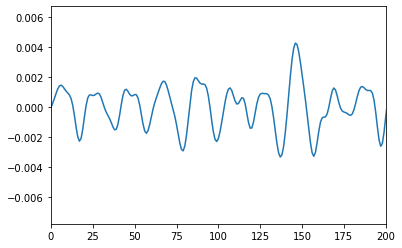

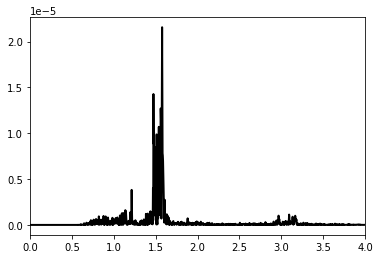

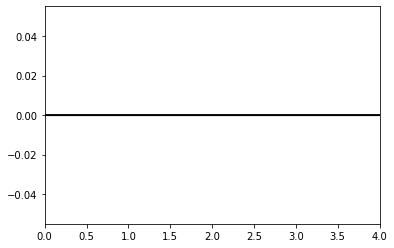

In [115]:
# 필터링 후 정규화 실험해보기.
from hrvanalysis import get_frequency_domain_features
import csv
# cppg불러오기
sr=255
f = open('C:\\Users\\user\\Desktop\\update\\cppg9.csv', 'r', encoding='utf-8')
rdr = csv.reader(f)
for line in rdr:
    ppg_data=line
    #print(line)
print(type(ppg_data))

f.close()   

# list를 numpy array로
#ppg_data=np.array(ppg_data,dtype=np.uint64)

ppg_data=np.array(ppg_data)
ppg_data=ppg_data.astype(np.float64)

plt.plot(ppg_data)
plt.xlim([0, 2000])
plt.show()

# 주파수 스펙트럼
f, psd = scipy.signal.periodogram(ppg_data, fs=sr, window='hann')

plt.plot(f, psd, 'k', linewidth=2)    
plt.xlim([0, 4])
plt.show()

# filtering
filtered=FIR_filter(ppg_data,50,0.032,True) # rppg는 0.75~2.0  cppg 0.75~0.2

f, psd = scipy.signal.periodogram(filtered, fs=sr, window='hann')

plt.plot(f, psd, 'k', linewidth=2)    
plt.xlim([0, 4])
plt.show()



# 신호정규화 0~1사이값
ppg_scaled=normalization(filtered)
print(len(ppg_scaled))

filtered=ppg_scaled

#peak 검출
ppg_peaks,ppg_points= detect_peak(filtered,133) # peak의 y값과 x값 반환 , 100 , 11

#타임도메인 전환
time,ppg_peaks_x=Totimedomain(filtered,ppg_points,ppg_peaks) # 정규화데이터, 피크x, 피크y ( 그래프그려줌)

# hrv 분석
ppg_hrv=cal_hrv(ppg_peaks,ppg_peaks_x) # 5. hrv계산
ppg_frequency_features = get_frequency_domain_features(ppg_hrv)
print("ppg_hrv_analysis:",ppg_frequency_features)


# # 파일로 저장
# ppg_frequency_features['num']="12"
# print(ppg_frequency_features.values())
# f = open('D:\\prlab\\ysg\\HRV\\data\\hrv_feature\\cppg_scipy.csv','a', newline='')
# #fieldnames=cppg_frequency_features.keys()
# # print(fieldnames)
# wr = csv.writer(f)
# #wr.writerow(ppg_frequency_features.keys()) 
# wr.writerow(ppg_frequency_features.values()) 
# f.close()

## 3. butterwidth filter

# R-R Interval 구하기

In [33]:
# print(cppg_points.shape)
# print(rppg_points.shape)
def length(x1,x2):
    return x2-x1

def cal_ppi(peak_x):
    ppi=np.zeros(len(peak_x)-1)
    print("ppi_shape:", ppi.shape)
    for i in range (len(peak_x)-1):
        peak_dist= length(peak_x[i],peak_x[i+1]) #x축사이의 거리만 (시간차 를 보는 것)
        ppi[i]=peak_dist
    #print(hrv)
    return ppi

# 개별실행

 cppg file name :  C:\Users\user\Desktop\update\ppg_signal\cppg\cppg12.csv
<class 'numpy.ndarray'>


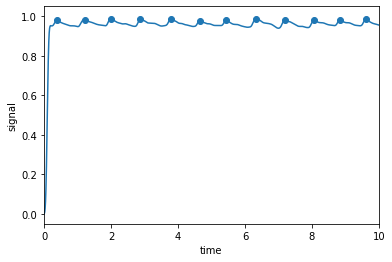

ppi_shape: (449,)
rppg file name :  C:\Users\user\Desktop\update\ppg_signal\rppg\rppg12.csv


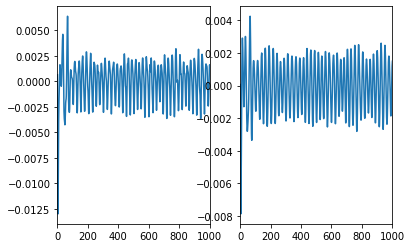

<class 'numpy.ndarray'>


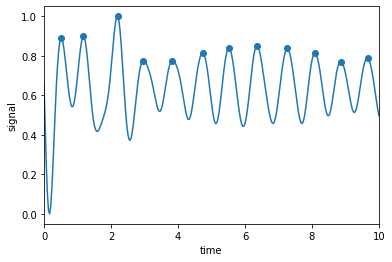

ppi_shape: (449,)


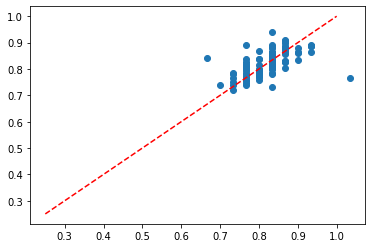

 cppg_hrv {'lf': 1.6751952616606433e-05, 'hf': 3.871780128250649e-05, 'lf_hf_ratio': 0.4326679734310046, 'lfnu': 30.200156732395982, 'hfnu': 69.79984326760402, 'total_power': 6.105573689463524e-05, 'vlf': 5.585982995522322e-06}
 rppg_hrv  {'lf': 0.00010976444087178597, 'hf': 0.00025084640054317647, 'lf_hf_ratio': 0.43757630420091664, 'lfnu': 30.438475016750182, 'hfnu': 69.56152498324983, 'total_power': 0.0003972666800681159, 'vlf': 3.665583865315344e-05}


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


In [131]:
i=12
# path 설정
cppg_path="C:\\Users\\user\\Desktop\\update\\ppg_signal\\cppg\\cppg12.csv"

rppg_path="C:\\Users\\user\\Desktop\\update\\ppg_signal\\rppg\\rppg12.csv"

#cppg
print(" cppg file name : ", cppg_path)
cppg_ppi=ppg_ppi_analysis(cppg_path, 255, True, 130)


#rppg
print( "rppg file name : ", rppg_path)
rppg_ppi=ppg_ppi_analysis(rppg_path, 30, False, 12)


# ppi 시각화
if len(cppg_ppi)>len(rppg_ppi):
    cppg_ppi=cppg_ppi[:len(rppg_ppi)]
elif len(cppg_ppi)<len(rppg_ppi):
    rppg_ppi=rppg_ppi[:len(cppg_ppi)]

plt.scatter(rppg_ppi[:100],cppg_ppi[:100])
plt.plot([0.25,1],[0.25,1],color='red',linestyle='--')
plt.show()

# hrv분석
cppg_frequency_features = get_frequency_domain_features(cppg_ppi)
rppg_frequency_features = get_frequency_domain_features(rppg_ppi)

print(" cppg_hrv",cppg_frequency_features )
print(" rppg_hrv ",rppg_frequency_features)

#  csv로 결과 저장
# 1. cppg
cppg_frequency_features['num']= i
f = open('C:\\Users\\user\\Desktop\\update\\ppg_signal\\cppg_fir_rppg_band.csv','a', newline='')
wr = csv.writer(f)
if i==1:
    wr.writerow(cppg_frequency_features.keys()) 
wr.writerow(cppg_frequency_features.values()) 
f.close()

# 2. rppg
rppg_frequency_features['num']= i
f = open('C:\\Users\\user\\Desktop\\update\\ppg_signal\\rppg_band.csv','a', newline='')
wr = csv.writer(f)
if i==1:
    wr.writerow(rppg_frequency_features.keys()) 
wr.writerow(rppg_frequency_features.values()) 
f.close()

# main

In [117]:
# rppg code
def ppg_ppi_analysis(path,sr,processing,distance):
    # 1. load data
    ppg_data=load_data(path)
    ppg_data=np.array(ppg_data) # list를 numpy array로
    ppg_data=ppg_data.astype(np.float64)
    
    if processing ==True :
        #filtered=preprocessing(ppg_data,2.0,0.75,sr)
        filtered=FIR_filter(ppg_data,50,0.032,True)
    else :
        filtered=preprocessing(ppg_data,2.0,0.75,sr)
    
    # 2. 신호정규화 0~1사이값
    ppg_scaled=normalization(filtered)

    # 3. peak 검출
    peaks_y,peaks_x= detect_peak(ppg_scaled,distance) # peak의 y값과 x값 반환.

    # 4, 타임도메인 전환
    time,time_peaks_x=Totimedomain(ppg_scaled,sr,peaks_x,peaks_y) # 정규화데이터, 피크x, 피크y ( 그래프그려줌)
    
    # 5. ppi 계산
    ppg_ppi=cal_ppi(time_peaks_x)
    
    # ppg x, y 데이터 반환
    return ppg_ppi

In [144]:
def main() :
    cppg_path="C:\\Users\\user\\Desktop\\update\\ppg_signal\\cppg"
    cppg_list=os.listdir(cppg_path)    
    print(" cppg_file_list : ",cppg_list)
        
    rppg_path="C:\\Users\\user\\Desktop\\update\\ppg_signal\\rppg"
    rppg_list=os.listdir(rppg_path)
    print(" rppg_file_list : ",rppg_list)
    
    for i in range (len(cppg_list)):
        # path 설정
        rppg_path_=rppg_path+'\\'+rppg_list[i]
        cppg_path_=cppg_path+'\\'+cppg_list[i]
        
        #cppg
        print(" file name : ", cppg_list[i])
        cppg_ppi=ppg_ppi_analysis(cppg_path_, 255, True, 133)
        
        
        #rppg
        print( " file name : ", rppg_list[i])
        rppg_ppi=ppg_ppi_analysis(rppg_path_, 30, False, 12)
        
        
        # ppi 시각화
        if len(cppg_ppi)>len(rppg_ppi):
            cppg_ppi=cppg_ppi[:len(rppg_ppi)]
        elif len(cppg_ppi)<len(rppg_ppi):
            rppg_ppi=rppg_ppi[:len(cppg_ppi)]
        plt.scatter(rppg_ppi,cppg_ppi)
        plt.plot([0.25,1.5],[0.25,1.5],color='red',linestyle='--')
        plt.show()
        
        # hrv분석
        cppg_frequency_features = get_frequency_domain_features(cppg_ppi)
        rppg_frequency_features = get_frequency_domain_features(rppg_ppi)
        
#         #  csv로 결과 저장
#         # 1. cppg
#         cppg_frequency_features['num']= i
#         f = open('D:\\prlab\\ysg\\HRV\\data\\hrv_feature\\cppg.csv','w', newline='')
#         wr = csv.writer(f)
#         if i==1:
#             wr.writerow(cppg_frequency_features.keys()) 
#         wr.writerow(cppg_frequency_features.values()) 
#         f.close()
        
#         # 2. rppg
#         rppg_frequency_features['num']= i
#         f = open('D:\\prlab\\ysg\\HRV\\data\\hrv_feature\\cppg.csv','w', newline='')
#         wr = csv.writer(f)
#         if i==1:
#             wr.writerow(rppg_frequency_features.keys()) 
#         wr.writerow(rppg_frequency_features.values()) 
#         f.close()

 cppg_file_list :  ['cppg1.csv', 'cppg10.csv', 'cppg11.csv', 'cppg12.csv', 'cppg2.csv', 'cppg3.csv', 'cppg4.csv', 'cppg5.csv', 'cppg6.csv', 'cppg7.csv', 'cppg8.csv', 'cppg9.csv']
 rppg_file_list :  ['rppg1.csv', 'rppg10.csv', 'rppg11.csv', 'rppg12.csv', 'rppg2.csv', 'rppg3.csv', 'rppg4.csv', 'rppg5.csv', 'rppg6.csv', 'rppg7.csv', 'rppg8.csv', 'rppg9.csv']
 file name :  cppg1.csv
<class 'numpy.ndarray'>


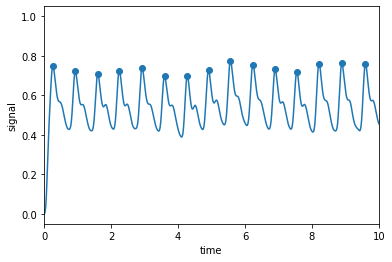

ppi_shape: (545,)
 file name :  rppg1.csv


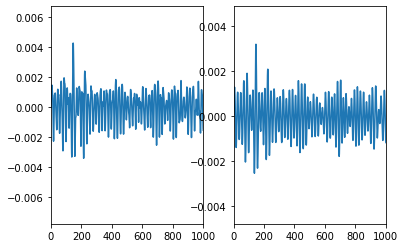

<class 'numpy.ndarray'>


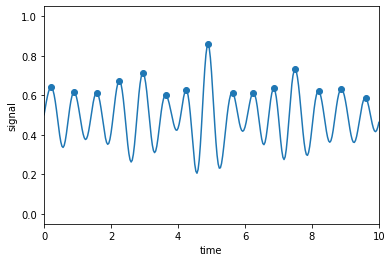

ppi_shape: (544,)


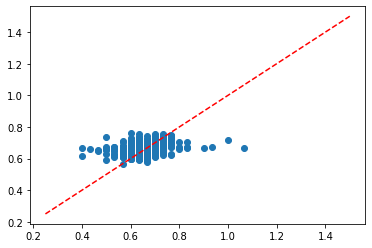

 file name :  cppg10.csv


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


<class 'numpy.ndarray'>


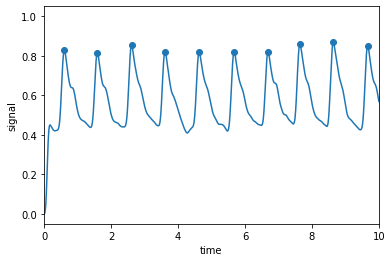

ppi_shape: (396,)
 file name :  rppg10.csv


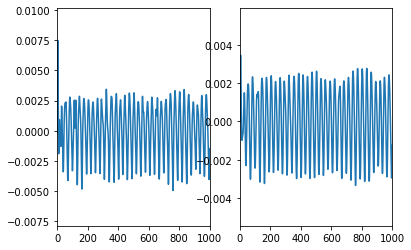

<class 'numpy.ndarray'>


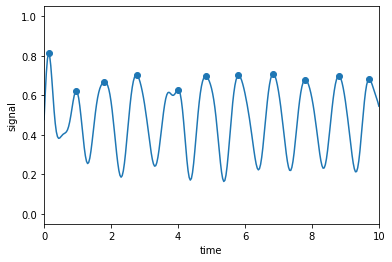

ppi_shape: (398,)


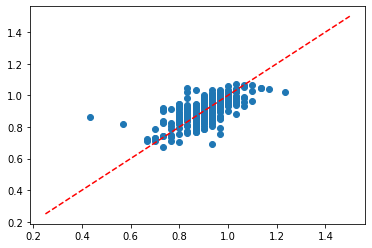

 file name :  cppg11.csv


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


<class 'numpy.ndarray'>


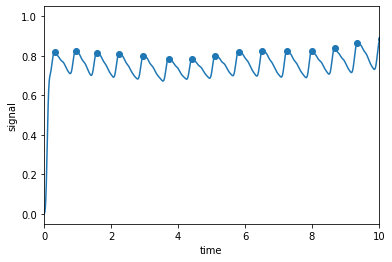

ppi_shape: (518,)
 file name :  rppg11.csv


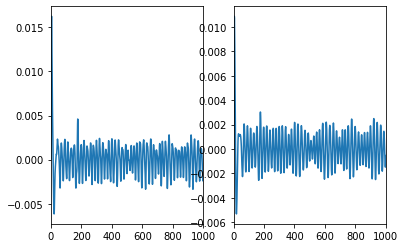

<class 'numpy.ndarray'>


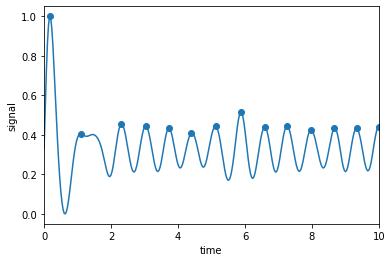

ppi_shape: (517,)


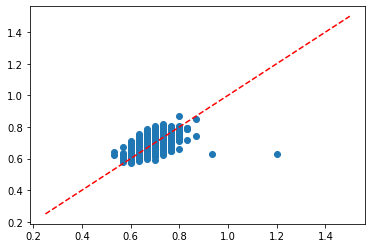

 file name :  cppg12.csv


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


<class 'numpy.ndarray'>


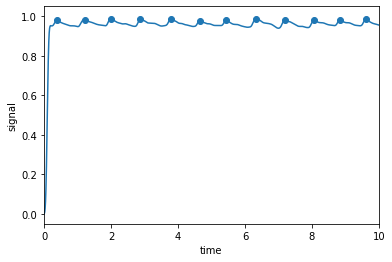

ppi_shape: (449,)
 file name :  rppg12.csv


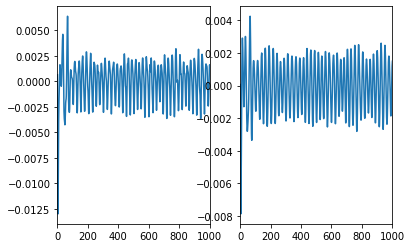

<class 'numpy.ndarray'>


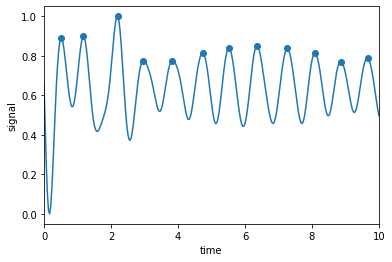

ppi_shape: (449,)


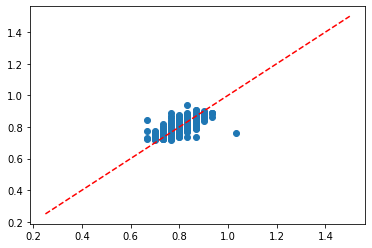

 file name :  cppg2.csv


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


<class 'numpy.ndarray'>


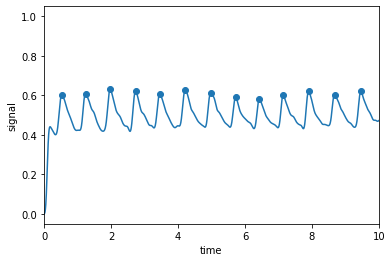

ppi_shape: (508,)
 file name :  rppg2.csv


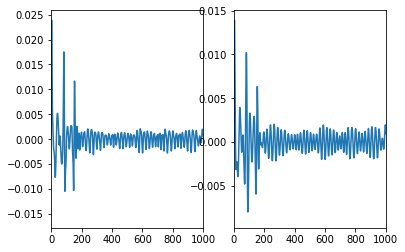

<class 'numpy.ndarray'>


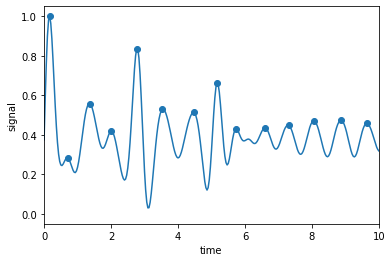

ppi_shape: (508,)


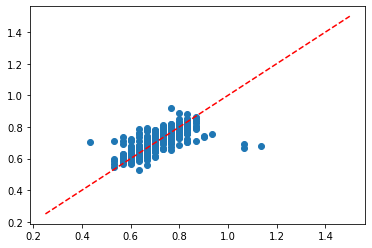

 file name :  cppg3.csv


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


<class 'numpy.ndarray'>


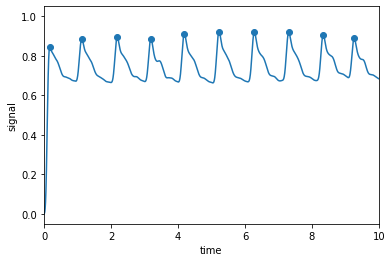

ppi_shape: (381,)
 file name :  rppg3.csv


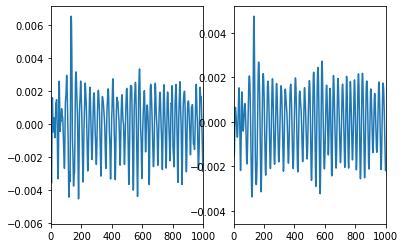

<class 'numpy.ndarray'>


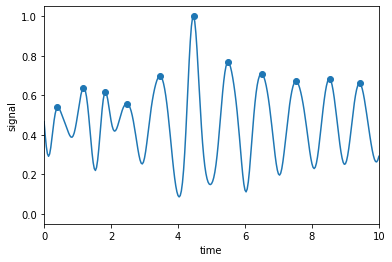

ppi_shape: (381,)


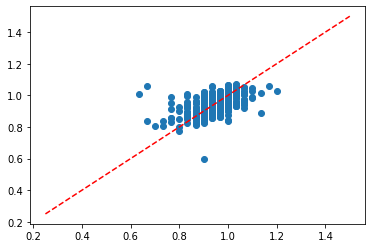

 file name :  cppg4.csv


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


<class 'numpy.ndarray'>


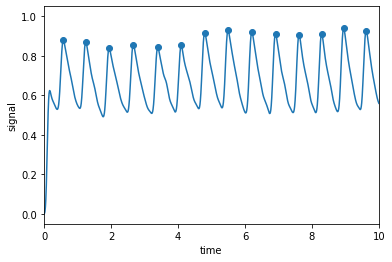

ppi_shape: (525,)
 file name :  rppg4.csv


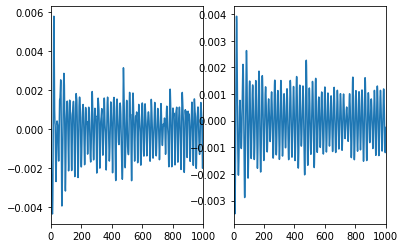

<class 'numpy.ndarray'>


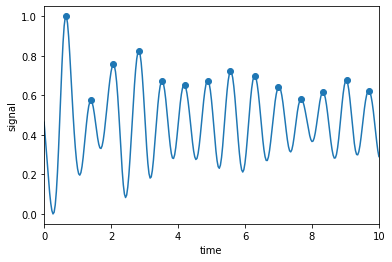

ppi_shape: (525,)


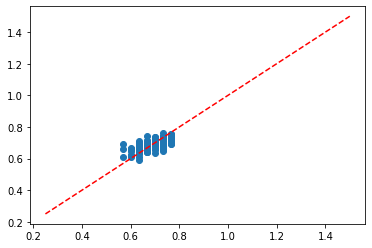

 file name :  cppg5.csv


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


<class 'numpy.ndarray'>


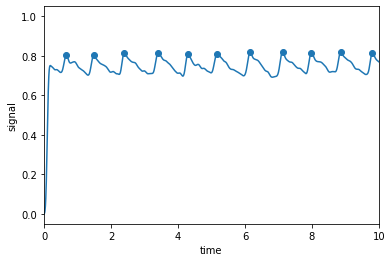

ppi_shape: (422,)
 file name :  rppg5.csv


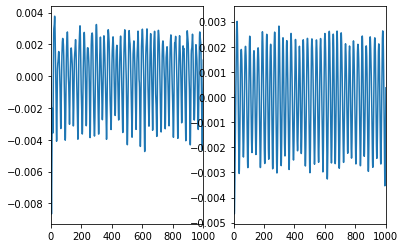

<class 'numpy.ndarray'>


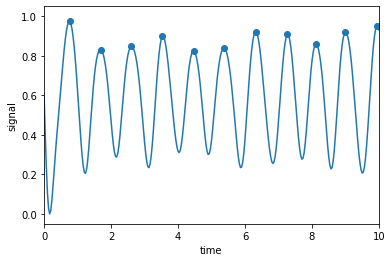

ppi_shape: (422,)


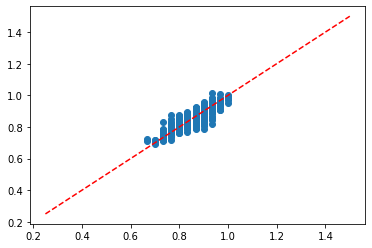

 file name :  cppg6.csv


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


<class 'numpy.ndarray'>


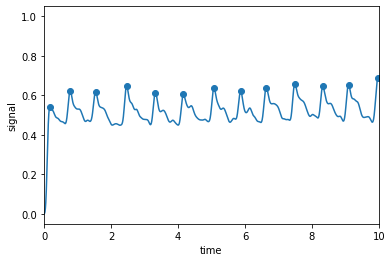

ppi_shape: (435,)
 file name :  rppg6.csv


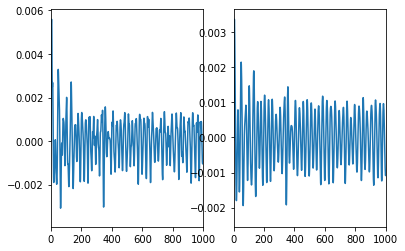

<class 'numpy.ndarray'>


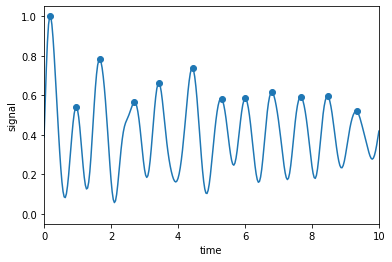

ppi_shape: (436,)


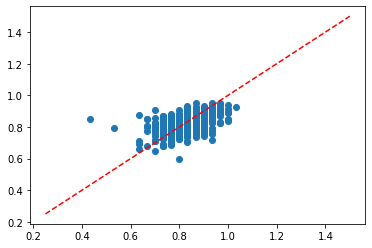

 file name :  cppg7.csv


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


<class 'numpy.ndarray'>


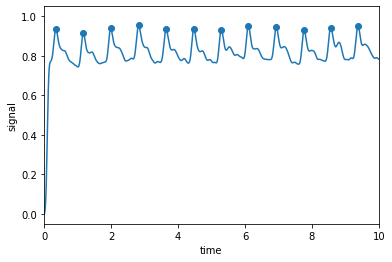

ppi_shape: (447,)
 file name :  rppg7.csv


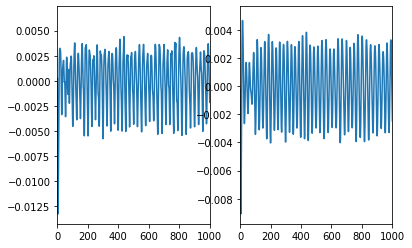

<class 'numpy.ndarray'>


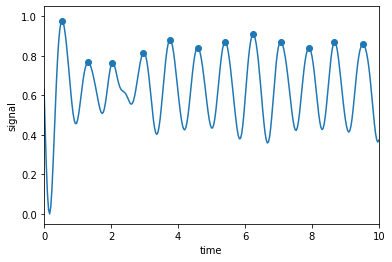

ppi_shape: (447,)


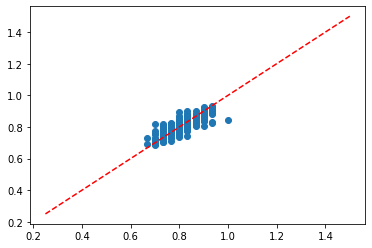

 file name :  cppg8.csv


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


<class 'numpy.ndarray'>


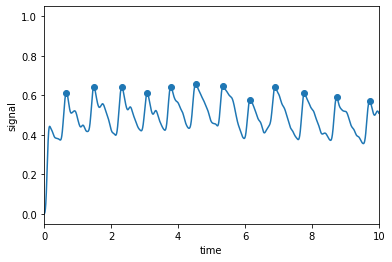

ppi_shape: (440,)
 file name :  rppg8.csv


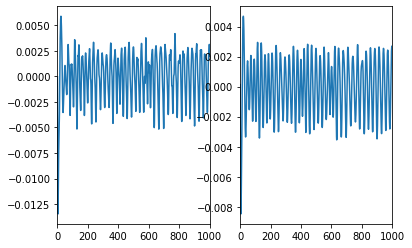

<class 'numpy.ndarray'>


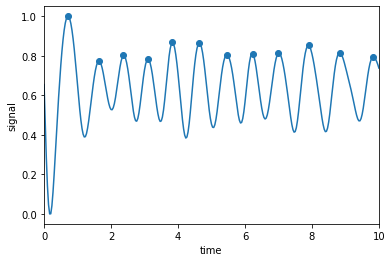

ppi_shape: (440,)


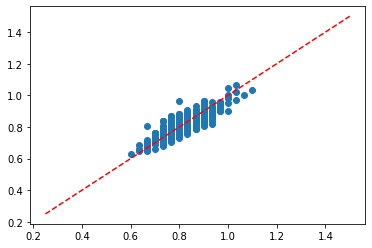

 file name :  cppg9.csv


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


<class 'numpy.ndarray'>


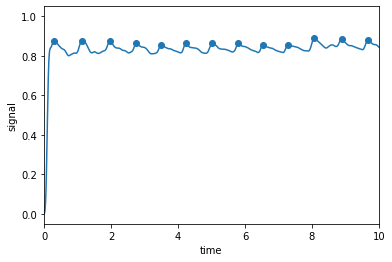

ppi_shape: (475,)
 file name :  rppg9.csv


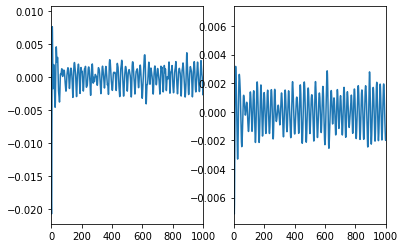

<class 'numpy.ndarray'>


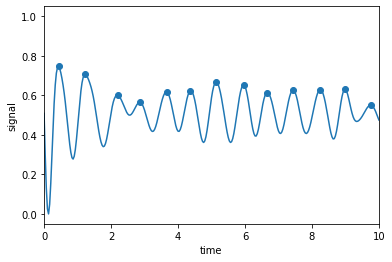

ppi_shape: (474,)


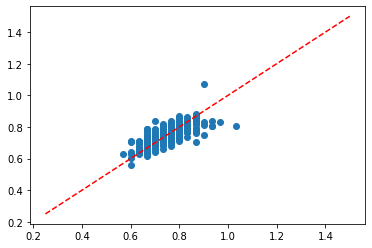

C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


In [145]:
main() # 지금은 c는 fir, r은 band 쓴것.